In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import urllib.request
import tarfile
import re
import unicodedata
import pandas as pd
from tqdm import tqdm
import math
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
class Config:
    # Data paths
    DATA_DIR = "./data"
    LJ_SPEECH_URL = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
    EXTRACTED_DIR = os.path.join(DATA_DIR, "LJSpeech-1.1")
    WAVS_DIR = os.path.join(EXTRACTED_DIR, "wavs")
    METADATA_FILE = os.path.join(EXTRACTED_DIR, "metadata.csv")
    
    # Audio preprocessing
    SAMPLE_RATE = 22050
    N_FFT = 1024
    HOP_LENGTH = 256
    N_MELS = 80
    
    # Model hyperparameters
    d_model = 512       # Transformer dimension
    nhead = 8           # Number of attention heads
    num_encoder_layers = 6
    dim_feedforward = 2048
    dropout = 0.1
    max_seq_len = 1000  # Maximum sequence length
    
    # Training parameters
    batch_size = 16
    learning_rate = 0.0001
    max_epochs = 25
    
    # Vocabulary
    vocab_size = 32     # Will be updated after processing text
    
# Text preprocessing functions
def normalize_text(text):
    """Basic text normalization"""
    # Convert to string in case input is numeric
    text = str(text)
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def build_vocab(texts):
    """Build character vocabulary from texts"""
    chars = set()
    for text in texts:
        for char in text:
            chars.add(char)
    
    # Special tokens
    special_tokens = ["<pad>", "<sos>", "<eos>", "<blank>"]
    
    # Create char to index mapping
    char_to_idx = {char: idx+len(special_tokens) for idx, char in enumerate(sorted(list(chars)))}
    
    # Add special tokens
    for idx, token in enumerate(special_tokens):
        char_to_idx[token] = idx
    
    # Create index to char mapping
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}
    
    return char_to_idx, idx_to_char

class LJSpeechProcessor:
    """Helper class to download, extract and process LJSpeech dataset"""
    
    def __init__(self, config):
        self.config = config
        self.char_to_idx = None
        self.idx_to_char = None
        
        # Create data directory if it doesn't exist
        os.makedirs(self.config.DATA_DIR, exist_ok=True)
        
    def download_and_extract(self):
        """Download and extract LJSpeech dataset"""
        # Check if already extracted
        if os.path.exists(self.config.EXTRACTED_DIR):
            print("Dataset already extracted.")
            return
        
        # Check if tar file exists
        tar_file = os.path.join(self.config.DATA_DIR, "LJSpeech-1.1.tar.bz2")
        if not os.path.exists(tar_file):
            print("Downloading LJSpeech dataset...")
            urllib.request.urlretrieve(self.config.LJ_SPEECH_URL, tar_file)
            
        # Extract tar file
        print("Extracting LJSpeech dataset...")
        with tarfile.open(tar_file, "r:bz2") as tar:
            tar.extractall(path=self.config.DATA_DIR)
            
        print(f"Dataset extracted to {self.config.EXTRACTED_DIR}")
        
    def load_metadata(self):
        """Load metadata from file"""
        metadata_df = pd.read_csv(self.config.METADATA_FILE, sep="|", header=None)
        metadata_df.columns = ["ID", "Transcription", "Normalized_Transcription"]
        
        # Verify columns and print first few rows
        print("Metadata columns:", metadata_df.columns.tolist())
        print("First few entries of normalized transcription:", metadata_df["Normalized_Transcription"].head())
        
        # Check for NaN or float values
        if metadata_df["Normalized_Transcription"].isna().any():
            print("Warning: Found NaN values in Normalized_Transcription. These will be converted to empty strings.")
            metadata_df["Normalized_Transcription"] = metadata_df["Normalized_Transcription"].fillna("")
        
        # Ensure all text entries are strings
        metadata_df["Normalized_Transcription"] = metadata_df["Normalized_Transcription"].astype(str)
        
        return metadata_df
    
    def preprocess_text(self, metadata_df):
        """Preprocess text data and build vocabulary"""
        # Apply more normalization
        preprocessed_texts = [normalize_text(text) for text in metadata_df["Normalized_Transcription"]]
        
        # Build vocabulary
        self.char_to_idx, self.idx_to_char = build_vocab(preprocessed_texts)
        
        # Update vocab size in config
        self.config.vocab_size = len(self.char_to_idx)
        
        print(f"Vocabulary size: {self.config.vocab_size}")
        print(f"Sample characters: {list(self.char_to_idx.keys())[:10]}...")
        
        return preprocessed_texts
    
    def text_to_indices(self, text):
        """Convert text to index sequence"""
        # Add start and end tokens
        indices = [self.char_to_idx["<sos>"]]
        indices.extend([self.char_to_idx[char] for char in text])
        indices.append(self.char_to_idx["<eos>"])
        return indices
    
    def indices_to_text(self, indices):
        """Convert index sequence to text"""
        text = ""
        for idx in indices:
            if idx == self.char_to_idx["<eos>"]:
                break
            if idx == self.char_to_idx["<sos>"] or idx == self.char_to_idx["<pad>"] or idx == self.char_to_idx["<blank>"]:
                continue
            text += self.idx_to_char[idx]
        return text
    
# Audio feature extraction
class AudioFeatureExtractor:
    """Helper class for audio feature extraction"""
    
    def __init__(self, config):
        self.config = config
        # Don't move the transform to device yet - let's do this at extraction time
        self.mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.SAMPLE_RATE,
            n_fft=config.N_FFT,
            hop_length=config.HOP_LENGTH,
            n_mels=config.N_MELS
        )
        
    def extract_features(self, audio_path):
        """Extract mel spectrogram features from audio file"""
        # Load audio
        waveform, sample_rate = torchaudio.load(audio_path)
        
        # Resample if needed
        if sample_rate != self.config.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sample_rate, self.config.SAMPLE_RATE)
            waveform = resampler(waveform)
        
        # Convert to mono if stereo
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Move both waveform and transform to the same device
        waveform = waveform.to(device)
        mel_spectrogram_transform = self.mel_spectrogram_transform.to(device)
            
        # Extract mel spectrogram
        mel_spectrogram = mel_spectrogram_transform(waveform)
        
        # Convert to decibel scale
        mel_spectrogram = torchaudio.transforms.AmplitudeToDB().to(device)(mel_spectrogram)
        
        # Transpose to time-major format (T, n_mels)
        mel_spectrogram = mel_spectrogram.squeeze(0).transpose(0, 1)
        
        return mel_spectrogram
    
    def pad_sequence(self, features, max_len):
        """Pad or truncate features to a fixed length"""
        if features.size(0) > max_len:
            # Truncate
            features = features[:max_len, :]
        elif features.size(0) < max_len:
            # Pad with zeros
            padding = torch.zeros(max_len - features.size(0), features.size(1), device=features.device)
            features = torch.cat([features, padding], dim=0)
        return features
    
# Dataset class
class LJSpeechDataset(Dataset):
    """LJSpeech dataset"""
    
    def __init__(self, metadata_df, processed_texts, config, processor, feature_extractor, is_training=True):
        self.metadata_df = metadata_df
        self.processed_texts = processed_texts
        self.config = config
        self.processor = processor
        self.feature_extractor = feature_extractor
        self.is_training = is_training
        
        # Process IDs
        self.file_ids = metadata_df["ID"].tolist()
        
    def __len__(self):
        return len(self.file_ids)
    
    def __getitem__(self, idx):
        file_id = self.file_ids[idx]
        text = self.processed_texts[idx]
        
        # Get audio path
        audio_path = os.path.join(self.config.WAVS_DIR, f"{file_id}.wav")
        
        # Extract features
        try:
            features = self.feature_extractor.extract_features(audio_path)
            # Move features to CPU for dataset storage
            features = features.cpu()
        except Exception as e:
            print(f"Error processing audio {file_id}: {e}")
            # Return dummy data in case of error
            return {
                "id": file_id,
                "features": torch.zeros(100, self.config.N_MELS),
                "feature_lengths": torch.tensor(100),
                "text_indices": torch.tensor([0, 0]),
                "text_lengths": torch.tensor(2),
                "text": ""
            }
        
        # Convert text to indices
        text_indices = self.processor.text_to_indices(text)
        
        # Prepare output
        output = {
            "id": file_id,
            "features": features,
            "feature_lengths": torch.tensor(features.size(0)),
            "text_indices": torch.tensor(text_indices),
            "text_lengths": torch.tensor(len(text_indices)),
            "text": text
        }
        
        return output

# Collate function for batching
def collate_fn(batch):
    """Collate function for batching"""
    
    # Get batch info
    ids = [item["id"] for item in batch]
    texts = [item["text"] for item in batch]
    
    # Get feature lengths and text lengths
    feature_lengths = torch.stack([item["feature_lengths"] for item in batch])
    text_lengths = torch.stack([item["text_lengths"] for item in batch])
    
    # Get max lengths
    max_feature_len = feature_lengths.max().item()
    max_text_len = text_lengths.max().item()
    
    # Prepare batch tensors
    batch_size = len(batch)
    
    # Prepare feature batch
    feature_batch = torch.zeros(batch_size, max_feature_len, batch[0]["features"].size(1))
    
    # Prepare text batch
    text_batch = torch.full((batch_size, max_text_len), 0)  # Pad with 0 (<pad> token)
    
    # Fill batches
    for i, item in enumerate(batch):
        features = item["features"]
        text_indices = item["text_indices"]
        
        # Copy features and text indices
        feature_len = features.size(0)
        text_len = len(text_indices)
        
        feature_batch[i, :feature_len, :] = features
        text_batch[i, :text_len] = torch.tensor(text_indices)
    
    return {
        "ids": ids,
        "feature_batch": feature_batch,
        "feature_lengths": feature_lengths,
        "text_batch": text_batch,
        "text_lengths": text_lengths,
        "texts": texts
    }

# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    """
    Positional encoding for transformer
    """
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Dual-Head Transformer Model
class DualHeadTransformer(nn.Module):
    """
    Transformer encoder with two heads:
    1. CTC head for sequence labeling
    2. Decoder head for autoregressive decoding
    """
    def __init__(self, config):
        super(DualHeadTransformer, self).__init__()
        self.config = config
        
        # Input projection
        self.input_projection = nn.Linear(config.N_MELS, config.d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(config.d_model, config.max_seq_len, config.dropout)
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=config.d_model, 
                                                  nhead=config.nhead,
                                                  dim_feedforward=config.dim_feedforward,
                                                  dropout=config.dropout)
        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=config.num_encoder_layers)
        
        # CTC Head
        self.ctc_head = nn.Linear(config.d_model, config.vocab_size)
        
        # Decoder embeddings
        self.decoder_embedding = nn.Embedding(config.vocab_size, config.d_model)
        
        # Decoder
        decoder_layers = nn.TransformerDecoderLayer(d_model=config.d_model, 
                                                  nhead=config.nhead,
                                                  dim_feedforward=config.dim_feedforward,
                                                  dropout=config.dropout)
        self.decoder = nn.TransformerDecoder(decoder_layers, num_layers=config.num_encoder_layers)
        
        # Output projection
        self.output_projection = nn.Linear(config.d_model, config.vocab_size)
        
    def create_padding_mask(self, lengths, max_len):
        """Create padding mask from lengths"""
        batch_size = lengths.size(0)
        # Create mask on the same device as the lengths tensor
        mask = torch.ones(batch_size, max_len, device=lengths.device)
        
        for i in range(batch_size):
            mask[i, :lengths[i]] = 0
        
        return mask.bool()
        
    def forward(self, features, feature_lengths, text=None, text_lengths=None):
        """
        Forward pass
        
        Args:
            features: (batch_size, time, n_mels)
            feature_lengths: (batch_size)
            text: (batch_size, text_len)
            text_lengths: (batch_size)
            
        Returns:
            ctc_logits: CTC logits
            decoder_logits: Decoder logits (if text is provided)
        """
        batch_size, max_time, _ = features.size()
        
        # Create padding mask for encoder
        encoder_padding_mask = self.create_padding_mask(feature_lengths, max_time)
        
        # Project and transpose to time-first
        x = self.input_projection(features).transpose(0, 1)  # (time, batch, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Encoder
        memory = self.encoder(x, src_key_padding_mask=encoder_padding_mask)  # (time, batch, d_model)
        
        # CTC Head (time-first to batch-first)
        ctc_logits = self.ctc_head(memory).transpose(0, 1)  # (batch, time, vocab_size)
        
        decoder_logits = None
        
        # Decoder (if training or text is provided)
        if text is not None:
            # Shift right for teacher forcing
            decoder_input = torch.cat([
                torch.full((batch_size, 1), 1, device=text.device),  # <sos> token
                text[:, :-1]
            ], dim=1)
            
            # Create mask for decoder padding
            tgt_padding_mask = self.create_padding_mask(text_lengths, text.size(1))
            
            # Create causal mask
            tgt_mask = torch.triu(
                torch.ones(text.size(1), text.size(1), device=text.device) * float('-inf'),
                diagonal=1
            )
            
            # Get embeddings
            tgt_embeddings = self.decoder_embedding(decoder_input).transpose(0, 1)  # (seq, batch, d_model)
            
            # Run decoder
            decoder_output = self.decoder(
                tgt_embeddings, memory,
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_padding_mask,
                memory_key_padding_mask=encoder_padding_mask
            )
            
            # Output projection
            decoder_logits = self.output_projection(decoder_output).transpose(0, 1)  # (batch, seq, vocab_size)
            
        return ctc_logits, decoder_logits

# Loss function
class DualHeadLoss(nn.Module):
    """Loss function for dual-head model"""
    
    def __init__(self, blank_idx=3, ctc_weight=0.7):  # blank_idx for <blank> token
        super(DualHeadLoss, self).__init__()
        self.ctc_loss = nn.CTCLoss(blank=blank_idx, reduction='mean', zero_infinity=True)
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=0)  # ignore <pad> token
        self.ctc_weight = ctc_weight
        
    def forward(self, ctc_logits, decoder_logits, targets, input_lengths, target_lengths):
        # Strip <sos> and <eos> from targets for CTC
        # Ensure targets have at least length 2 to avoid errors
        ctc_targets = targets[:, 1:-1]  # Exclude first (<sos>) and last (<eos>) tokens
        ctc_target_lengths = torch.clamp(target_lengths - 2, min=1)  # Adjust lengths
        
        # Handle edge cases where targets become too short
        valid_mask = (ctc_target_lengths > 0) & (ctc_targets.size(1) > 0)
        if not valid_mask.all():
            # Filter out invalid entries (if any)
            valid_indices = valid_mask.nonzero(as_tuple=True)[0]
            ctc_logits = ctc_logits[valid_indices]
            ctc_targets = ctc_targets[valid_indices]
            input_lengths = input_lengths[valid_indices]
            ctc_target_lengths = ctc_target_lengths[valid_indices]
            if ctc_logits.size(0) == 0:
                ctc_loss_val = torch.tensor(0.0, device=ctc_logits.device)
            else:
                ctc_logits_tm = ctc_logits.transpose(0, 1)
                ctc_loss_val = self.ctc_loss(
                    ctc_logits_tm.log_softmax(2), 
                    ctc_targets, 
                    input_lengths, 
                    ctc_target_lengths
                )
        else:
            ctc_logits_tm = ctc_logits.transpose(0, 1)
            ctc_loss_val = self.ctc_loss(
                ctc_logits_tm.log_softmax(2), 
                ctc_targets, 
                input_lengths, 
                ctc_target_lengths
            )
        
        # CE loss remains unchanged
        batch_size, seq_len, vocab_size = decoder_logits.size()
        ce_loss_val = self.ce_loss(
            decoder_logits.reshape(-1, vocab_size),
            targets.reshape(-1)
        )
        
        # Combined loss
        loss = self.ctc_weight * ctc_loss_val + (1 - self.ctc_weight) * ce_loss_val
        
        return loss, ctc_loss_val, ce_loss_val

# Main function
def main():
    print("Initializing LJSpeech Transformer with CTC and Decoder Heads...")
    
    # Configuration
    config = Config()
    
    # Initialize processor
    processor = LJSpeechProcessor(config)
    
    # Download and extract dataset
    processor.download_and_extract()
    
    # Load metadata
    print("Loading metadata...")
    metadata_df = processor.load_metadata()
    print(f"Found {len(metadata_df)} samples")
    
    # Check the first few rows
    print("\nSample metadata:")
    print(metadata_df.head())
    
    # Preprocess text
    print("\nPreprocessing text and building vocabulary...")
    processed_texts = processor.preprocess_text(metadata_df)
    
    # Initialize feature extractor
    print("\nInitializing audio feature extractor...")
    feature_extractor = AudioFeatureExtractor(config)
    
    # Verify feature extraction with a sample file
    sample_id = metadata_df["ID"].iloc[0]
    sample_path = os.path.join(config.WAVS_DIR, f"{sample_id}.wav")
    print(f"Extracting features from sample file: {sample_path}")
    
    sample_features = feature_extractor.extract_features(sample_path)
    print(f"Sample features shape: {sample_features.shape}")
    
    # Visualize mel spectrogram
    # First move sample_features to CPU for visualization
    sample_features_cpu = sample_features.cpu()
    plt.figure(figsize=(10, 4))
    plt.imshow(sample_features_cpu.numpy(), aspect='auto', origin='lower')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.savefig('sample_mel_spectrogram.png')
    plt.close()
    print("Saved sample mel spectrogram visualization to sample_mel_spectrogram.png")
    
    # Create dataset
    print("\nCreating dataset...")
    # Use a small subset for testing
    test_size = min(100, len(metadata_df))
    test_metadata_df = metadata_df.iloc[:test_size]
    test_processed_texts = processed_texts[:test_size]
    
    dataset = LJSpeechDataset(
        test_metadata_df, 
        test_processed_texts, 
        config, 
        processor, 
        feature_extractor
    )
    
    print(f"Created dataset with {len(dataset)} samples")
    
    # Test a sample from the dataset
    print("\nTesting a sample from the dataset...")
    sample_item = dataset[0]
    print(f"Sample ID: {sample_item['id']}")
    print(f"Features shape: {sample_item['features'].shape}")
    print(f"Feature length: {sample_item['feature_lengths']}")
    print(f"Text: {sample_item['text']}")
    print(f"Text indices: {sample_item['text_indices']}")
    print(f"Text length: {sample_item['text_lengths']}")
    
    # Create dataloader
    print("\nCreating dataloader...")
    dataloader = DataLoader(
        dataset, 
        batch_size=4, 
        shuffle=True, 
        collate_fn=collate_fn
    )
    
    # Test a batch from the dataloader
    print("\nTesting a batch from the dataloader...")
    sample_batch = next(iter(dataloader))
    print(f"Batch IDs: {sample_batch['ids']}")
    print(f"Feature batch shape: {sample_batch['feature_batch'].shape}")
    print(f"Feature lengths: {sample_batch['feature_lengths']}")
    print(f"Text batch shape: {sample_batch['text_batch'].shape}")
    print(f"Text lengths: {sample_batch['text_lengths']}")
    print(f"Texts: {sample_batch['texts']}")
    
    # Initialize model
    print("\nInitializing model...")
    model = DualHeadTransformer(config).to(device)
    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Test forward pass
    print("\nTesting forward pass...")
    sample_feature_batch = sample_batch['feature_batch'].to(device)
    sample_feature_lengths = sample_batch['feature_lengths'].to(device)
    sample_text_batch = sample_batch['text_batch'].to(device)
    sample_text_lengths = sample_batch['text_lengths'].to(device)
    
    ctc_logits, decoder_logits = model(
        sample_feature_batch, 
        sample_feature_lengths, 
        sample_text_batch, 
        sample_text_lengths
    )
    
    print(f"CTC logits shape: {ctc_logits.shape}")
    print(f"Decoder logits shape: {decoder_logits.shape}")
    
    # Initialize loss function
    print("\nInitializing loss function...")
    loss_fn = DualHeadLoss().to(device)
    
    # Test loss calculation
    print("\nTesting loss calculation...")
    loss, ctc_loss, ce_loss = loss_fn(
        ctc_logits, 
        decoder_logits, 
        sample_text_batch, 
        sample_feature_lengths, 
        sample_text_lengths
    )
    
    print(f"Combined loss: {loss.item()}")
    print(f"CTC loss: {ctc_loss.item()}")
    print(f"CE loss: {ce_loss.item()}")
    
    print("\nSetup complete! The model is ready for training.")

if __name__ == "__main__":
    main()

Using device: cuda
Initializing LJSpeech Transformer with CTC and Decoder Heads...
Extracting LJSpeech dataset...
Dataset extracted to ./data/LJSpeech-1.1
Loading metadata...
Metadata columns: ['ID', 'Transcription', 'Normalized_Transcription']
First few entries of normalized transcription: 0    Printing, in the only sense with which we are ...
1                       in being comparatively modern.
2    For although the Chinese took impressions from...
3    produced the block books, which were the immed...
4    the invention of movable metal letters in the ...
Name: Normalized_Transcription, dtype: object
Found 13100 samples

Sample metadata:
           ID                                      Transcription  \
0  LJ001-0001  Printing, in the only sense with which we are ...   
1  LJ001-0002                     in being comparatively modern.   
2  LJ001-0003  For although the Chinese took impressions from...   
3  LJ001-0004  produced the block books, which were the immed...   
4  LJ001-

Initializing LJSpeech Transformer with CTC and Decoder Heads...
Dataset already extracted.
Loading metadata...
Metadata columns: ['ID', 'Transcription', 'Normalized_Transcription']
First few entries of normalized transcription: 0    Printing, in the only sense with which we are ...
1                       in being comparatively modern.
2    For although the Chinese took impressions from...
3    produced the block books, which were the immed...
4    the invention of movable metal letters in the ...
Name: Normalized_Transcription, dtype: object
Found 13100 samples

Preprocessing text and building vocabulary...
Vocabulary size: 31
Sample characters: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']...

Initializing audio feature extractor...

Creating dataset...
Created train dataset with 11790 samples
Created validation dataset with 1179 samples

Creating dataloaders...

Initializing model...
Model initialized with 44227646 parameters

Initializing loss function...

Starting training...

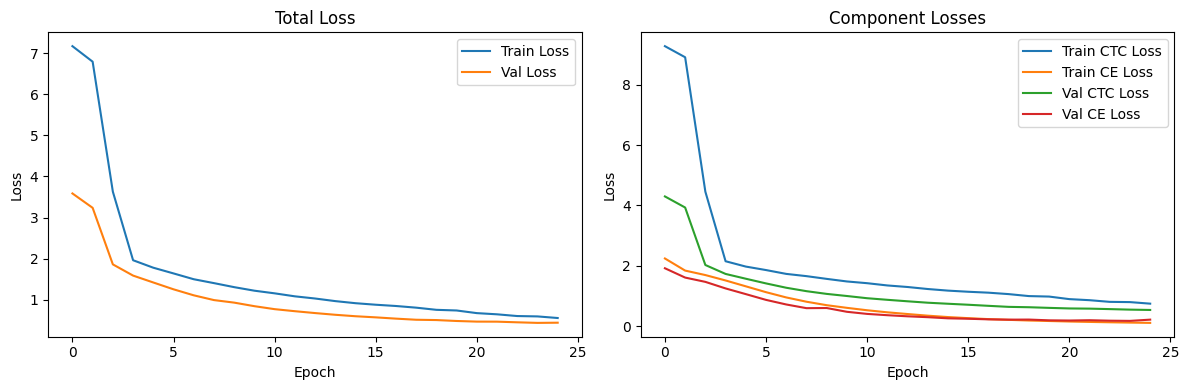

In [2]:
# Training function
def train(model, dataloader, loss_fn, optimizer, epoch, device, log_interval=10):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    total_ctc_loss = 0
    total_ce_loss = 0
    start_time = time.time()
    
    for batch_idx, batch in enumerate(dataloader):
        # Move data to device
        feature_batch = batch['feature_batch'].to(device)
        feature_lengths = batch['feature_lengths'].to(device)
        text_batch = batch['text_batch'].to(device)
        text_lengths = batch['text_lengths'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        ctc_logits, decoder_logits = model(
            feature_batch, 
            feature_lengths, 
            text_batch, 
            text_lengths
        )
        
        # Calculate loss
        loss, ctc_loss, ce_loss = loss_fn(
            ctc_logits, 
            decoder_logits, 
            text_batch, 
            feature_lengths, 
            text_lengths
        )
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
        total_ctc_loss += ctc_loss.item()
        total_ce_loss += ce_loss.item()
        
        # Log progress
        if batch_idx % log_interval == 0:
            elapsed = time.time() - start_time
            print(f'Epoch {epoch} | Batch {batch_idx}/{len(dataloader)} | '
                  f'Loss: {loss.item():.4f} | CTC: {ctc_loss.item():.4f} | CE: {ce_loss.item():.4f} | '
                  f'Time: {elapsed:.2f}s')
            start_time = time.time()
    
    # Calculate average loss
    avg_loss = total_loss / len(dataloader)
    avg_ctc_loss = total_ctc_loss / len(dataloader)
    avg_ce_loss = total_ce_loss / len(dataloader)
    
    return avg_loss, avg_ctc_loss, avg_ce_loss

# Validation function
def validate(model, dataloader, loss_fn, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_ctc_loss = 0
    total_ce_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            # Move data to device
            feature_batch = batch['feature_batch'].to(device)
            feature_lengths = batch['feature_lengths'].to(device)
            text_batch = batch['text_batch'].to(device)
            text_lengths = batch['text_lengths'].to(device)
            
            # Forward pass
            ctc_logits, decoder_logits = model(
                feature_batch, 
                feature_lengths, 
                text_batch, 
                text_lengths
            )
            
            # Calculate loss
            loss, ctc_loss, ce_loss = loss_fn(
                ctc_logits, 
                decoder_logits, 
                text_batch, 
                feature_lengths, 
                text_lengths
            )
            
            # Accumulate loss
            total_loss += loss.item()
            total_ctc_loss += ctc_loss.item()
            total_ce_loss += ce_loss.item()
    
    # Calculate average loss
    avg_loss = total_loss / len(dataloader)
    avg_ctc_loss = total_ctc_loss / len(dataloader)
    avg_ce_loss = total_ce_loss / len(dataloader)
    
    return avg_loss, avg_ctc_loss, avg_ce_loss

# Greedy CTC decode function
def greedy_ctc_decode(logits, idx_to_char, blank_idx=3):
    """
    Greedy CTC decoding algorithm
    
    Args:
        logits: (time, vocab_size) tensor
        idx_to_char: index to character mapping
        blank_idx: index of blank token
        
    Returns:
        decoded_text: decoded text without duplicates or blanks
    """
    # Get most probable character at each timestep
    indices = torch.argmax(logits, dim=1).tolist()
    
    # Remove duplicates and blanks
    prev = -1
    decoded_indices = []
    
    for idx in indices:
        if idx != blank_idx and idx != prev:
            decoded_indices.append(idx)
        prev = idx
    
    # Convert indices to text
    decoded_text = ''.join([idx_to_char[idx] for idx in decoded_indices if idx in idx_to_char])
    
    return decoded_text

# Infer function to test transcription
# Modified infer function to fix device mismatch issue
def infer(model, feature_extractor, processor, audio_path, config, device):
    """Infer text from audio"""
    model.eval()
    
    # Extract features
    features = feature_extractor.extract_features(audio_path)
    
    # Add batch dimension
    features = features.unsqueeze(0)
    
    # Move features to the same device as the model
    features = features.to(device)
    
    # Create feature lengths tensor and move to the same device
    feature_lengths = torch.tensor([features.size(1)], device=device)
    
    # Forward pass (CTC only)
    with torch.no_grad():
        ctc_logits, _ = model(features, feature_lengths)
    
    # Get CTC logits for first item in batch
    ctc_logits = ctc_logits[0]
    
    # Decode
    decoded_text = greedy_ctc_decode(ctc_logits, processor.idx_to_char)
    
    return decoded_text
# Training loop
def train_model(model, train_loader, val_loader, loss_fn, config, device, 
               feature_extractor, processor, checkpoint_dir="./checkpoints"):
    """Main training loop"""
    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # Initialize scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=True
    )
    
    # Initialize best validation loss
    best_val_loss = float('inf')
    
    # Training history
    history = {
        'train_loss': [],
        'train_ctc_loss': [],
        'train_ce_loss': [],
        'val_loss': [],
        'val_ctc_loss': [],
        'val_ce_loss': [],
    }
    
    # Sample audio for inference testing
    sample_audio_path = os.path.join(config.WAVS_DIR, f"{train_loader.dataset.file_ids[0]}.wav")
    
    # Main training loop
    for epoch in range(1, config.max_epochs + 1):
        print(f"\nEpoch {epoch}/{config.max_epochs}")
        
        # Train
        train_loss, train_ctc_loss, train_ce_loss = train(
            model, train_loader, loss_fn, optimizer, epoch, device
        )
        
        # Validate
        val_loss, val_ctc_loss, val_ce_loss = validate(
            model, val_loader, loss_fn, device
        )
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_ctc_loss'].append(train_ctc_loss)
        history['train_ce_loss'].append(train_ce_loss)
        history['val_loss'].append(val_loss)
        history['val_ctc_loss'].append(val_ctc_loss)
        history['val_ce_loss'].append(val_ce_loss)
        
        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f} | CTC: {train_ctc_loss:.4f} | CE: {train_ce_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f} | CTC: {val_ctc_loss:.4f} | CE: {val_ce_loss:.4f}")
        
        # Test inference
        decoded_text = infer(model, feature_extractor, processor, sample_audio_path, config, device)
        ground_truth = train_loader.dataset.processed_texts[0]
        print(f"Sample inference:")
        print(f"Ground truth: {ground_truth}")
        print(f"Prediction: {decoded_text}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_ctc_loss'], label='Train CTC Loss')
    plt.plot(history['train_ce_loss'], label='Train CE Loss')
    plt.plot(history['val_ctc_loss'], label='Val CTC Loss')
    plt.plot(history['val_ce_loss'], label='Val CE Loss')
    plt.title('Component Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    
    return history

# Modified main function with training
def main_with_training():
    import time
    print("Initializing LJSpeech Transformer with CTC and Decoder Heads...")
    
    # Configuration
    config = Config()
    
    # Initialize processor
    processor = LJSpeechProcessor(config)
    
    # Download and extract dataset
    processor.download_and_extract()
    
    # Load metadata
    print("Loading metadata...")
    metadata_df = processor.load_metadata()
    print(f"Found {len(metadata_df)} samples")
    
    # Preprocess text
    print("\nPreprocessing text and building vocabulary...")
    processed_texts = processor.preprocess_text(metadata_df)
    
    # Initialize feature extractor
    print("\nInitializing audio feature extractor...")
    feature_extractor = AudioFeatureExtractor(config)
    
    # Create full dataset
    print("\nCreating dataset...")
    # Use a subset for faster training
    train_size = len(metadata_df)
    # Split into train and validation sets (90% train, 10% val)
    train_size = int(0.9 * train_size)
    val_size = int(0.1 * train_size)
    
    train_metadata_df = metadata_df.iloc[:train_size]
    train_processed_texts = processed_texts[:train_size]
    
    val_metadata_df = metadata_df.iloc[train_size:train_size+val_size]
    val_processed_texts = processed_texts[train_size:train_size+val_size]
    
    train_dataset = LJSpeechDataset(
        train_metadata_df, 
        train_processed_texts, 
        config, 
        processor, 
        feature_extractor
    )
    
    val_dataset = LJSpeechDataset(
        val_metadata_df, 
        val_processed_texts, 
        config, 
        processor, 
        feature_extractor
    )
    
    print(f"Created train dataset with {len(train_dataset)} samples")
    print(f"Created validation dataset with {len(val_dataset)} samples")
    
    # Create dataloaders
    print("\nCreating dataloaders...")
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.batch_size, 
        shuffle=False, 
        collate_fn=collate_fn
    )
    
    # Initialize model
    print("\nInitializing model...")
    model = DualHeadTransformer(config).to(device)
    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Initialize loss function
    print("\nInitializing loss function...")
    loss_fn = DualHeadLoss().to(device)
    
    # Train model
    print("\nStarting training...")
    history = train_model(
        model, 
        train_loader, 
        val_loader, 
        loss_fn, 
        config, 
        device,
        feature_extractor,
        processor
    )
    
    print("\nTraining complete!")
    return model, history

if __name__ == "__main__":
    import time
    main_with_training()